In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import corner
import scipy 

In [35]:
#Modelo
def recta(x,a,b):
    return a*x + b

#Funcion para calcular la chi cuadrada
def chisq(theta,data):
    x = data[0]
    y = data[1]
    y_err = data[2]
    
    model = recta(x,theta[0],theta[1])
    chisq = (y-model)**2 / y_err**2
    
    return chisq.sum()

In [36]:
datos = np.load('fit_ejercise.npy')

In [37]:
x = datos[0]
y = datos[1]
y_err = datos[2]

Text(0,0.5,'y')

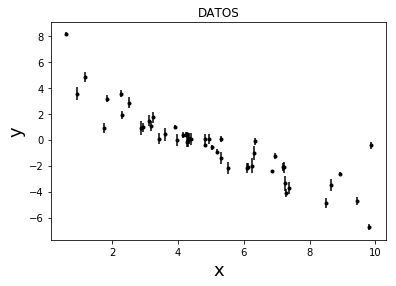

In [40]:
plt.errorbar(x,y,yerr=y_err, fmt='k.',ecolor='black')
plt.title("DATOS")
plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)

In [41]:
def metrop(a_ini,b_ini,data,sigm,flags):
    
    #Reordenamos el arreglo de a y b iniciales.
    a_ini = a_ini.T.reshape((len(a_ini),1))
    b_ini = b_ini.T.reshape((len(b_ini),1))
    data = np.array(data)
    
    ch_ini = [] #iniciamos lista para los valores de chi iniciales.
    
    #Llenamos chi_ini con los valores iniciales 
    for i in range(len(a_ini)):
        ch_ini.append(chisq([a_ini[i][0],b_ini[i][0]],data))
    
    #Transformamos a_ini de array a list para usar la función append.
    a = a_ini.tolist()
    b = b_ini.tolist()
    
    for i in range(len(a_ini)):
        ch_0 = ch_ini[i]
        k = 0
        for j in range(10000): 
            a_af = np.random.normal(a[i][k],sigm) 
            b_af = np.random.normal(b[i][k],sigm) 
            ch = chisq([a_af,b_af],data)
            if ch < ch_0:
                a[i].append(a_af)
                b[i].append(b_af)
                k = k+1
                ch_0 = ch
            else:
                r = -np.log(np.random.uniform(0,1)) 
                diff = abs(ch-ch_0)
                if diff<r:
                    a[i].append(a_af)
                    b[i].append(b_af)
                    k = k+1
                    ch_0 = ch

    # Parte de grafico
    plt.figure(figsize=(15,10))    
    
    plt.subplot(221)
    for i in range(len(a_ini)):     
        plt.scatter(a[i],b[i],s=1)
    plt.ylabel('b',fontsize=18)
    plt.xlabel('a',fontsize=18)
    
    a_tot = np.array([])
    b_tot = np.array([])
    for i in range(len(a_ini)): 
        a_tot = np.append(a_tot,a[i][flags:])
        b_tot = np.append(b_tot,b[i][flags:])
    
    plt.subplot(222)
    plt.scatter(a_tot,b_tot,s=1)
    plt.xlabel('a',fontsize=18)
    plt.show();
    
    return a_tot , b_tot, a, b

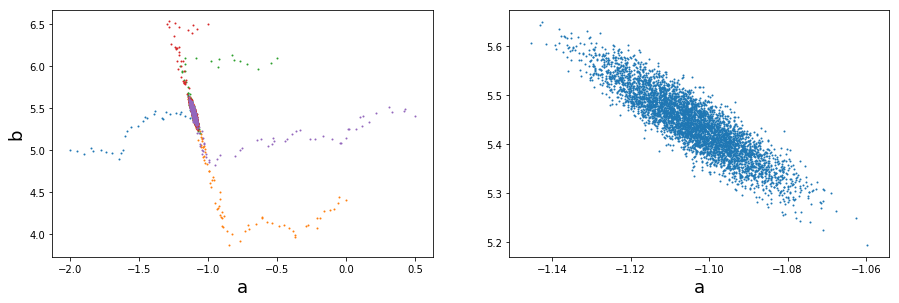

In [42]:
data = [x,y,y_err]
sigma = 0.05
a_ini = np.array([-2.0,0.0,-0.5,-1,0.5])
b_ini = np.array([5.0,4.4,6.1,6.5,5.4])
flags = 100
a,b, a_T,b_T= metrop(a_ini,b_ini,data,sigma,flags)

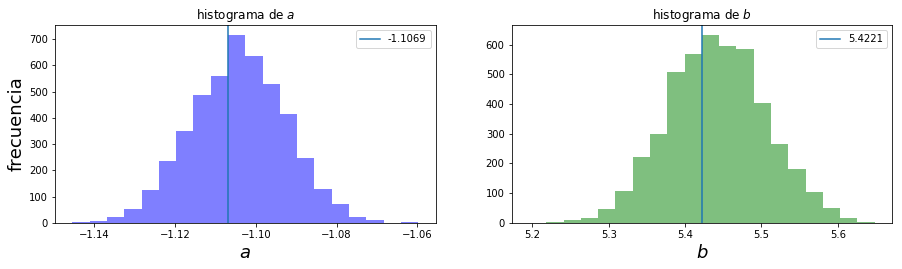

In [59]:
plt.figure(figsize=(15,8))
plt.subplot(221)
hist_a = plt.hist(a, bins=20,facecolor='blue',alpha = 0.5)
a_t = np.max(hist_a[1][np.where(hist_a[0] == np.max(hist_a[0]))[0][0]])
plt.axvline(a_t,label = np.round(a_t,4))
plt.title("histograma de $a$")
plt.xlabel("$a$",fontsize=18)
plt.ylabel("frecuencia",fontsize=18)
plt.legend();

plt.subplot(222)
hist_b = plt.hist(b, bins=20,facecolor='g', alpha = 0.5)
b_t = np.max(hist_b[1][np.where(hist_b[0] == np.max(hist_b[0]))[0][0]])
plt.axvline(b_t,label = np.round(b_t,4))
plt.title("histograma de $b$")
plt.xlabel("$b$",fontsize=18)
plt.legend();

In [60]:
x_t = np.linspace(-1,11,1000)
y_t  = x_t*a_t + b_t

Text(0,0.5,'y')

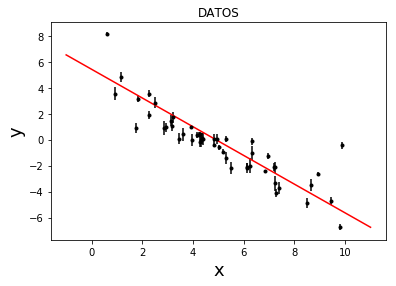

In [61]:
plt.errorbar(x,y,yerr=y_err, fmt='k.',ecolor='black')
plt.plot(x_t,y_t,'-r')
plt.title("DATOS")
plt.xlabel("x",fontsize=18)
plt.ylabel("y",fontsize=18)

In [63]:
#Funcion para calcular la chi cuadrada con otro parametro 
def chisq_2(theta,data):
    x = data[0]
    y = data[1]
    y_err = data[2]
    
    model = recta(x,theta[0],theta[1])
    chisq = (y-model)**2 / (y_err**2 + (model**2)*(theta[2]**2))
    
    return chisq.sum()

In [65]:
def metrop(a_ini,b_ini,f_ini,data,sigm,flags):
    
    #Reordenamos el arreglo de a y b iniciales.
    a_ini = a_ini.T.reshape((len(a_ini),1))
    b_ini = b_ini.T.reshape((len(b_ini),1))
    f_ini = b_ini.T.reshape((len(f_ini),1))
    data = np.array(data)
    
    ch_ini = [] #iniciamos lista para los valores de chi iniciales.
    
    #Llenamos chi_ini con los valores iniciales 
    for i in range(len(a_ini)):
        ch_ini.append(chisq_2([a_ini[i][0],b_ini[i][0],f_ini[i][0]],data))
    
    #Transformamos a_ini de array a list para usar la función append.
    a = a_ini.tolist()
    b = b_ini.tolist()
    f = f_ini.tolist()
    
    for i in range(len(a_ini)):
        ch_0 = ch_ini[i]
        k = 0
        for j in range(10000): 
            a_af = np.random.normal(a[i][k],sigm) 
            b_af = np.random.normal(b[i][k],sigm)
            f_af = np.random.normal(f[i][k],sigm) 
            ch = chisq([a_af,b_af,f_af],data)
            if ch < ch_0:
                a[i].append(a_af)
                b[i].append(b_af)
                f[i].append(f_af)
                k = k+1
                ch_0 = ch
            else:
                r = -np.log(np.random.uniform(0,1)) 
                diff = abs(ch-ch_0)
                if diff<r:
                    a[i].append(a_af)
                    b[i].append(b_af)
                    f[i].append(f_af)
                    k = k+1
                    ch_0 = ch

    # Parte de grafico
    plt.figure(figsize=(15,10))    
    
    plt.subplot(221)
    for i in range(len(a_ini)):     
        plt.scatter(a[i],b[i],s=1)
    plt.ylabel('b',fontsize=18)
    plt.xlabel('a',fontsize=18)
    
    a_tot = np.array([])
    b_tot = np.array([])
    f_tot = np.array([])
    for i in range(len(a_ini)): 
        a_tot = np.append(a_tot,a[i][flags:])
        b_tot = np.append(b_tot,b[i][flags:])
        f_tot = np.append(f_tot,f[i][flags:])
    
    plt.subplot(222)
    plt.scatter(a_tot,b_tot,s=1)
    plt.xlabel('a',fontsize=18)
    plt.show();
    
    return a_tot , b_tot, a, b, f

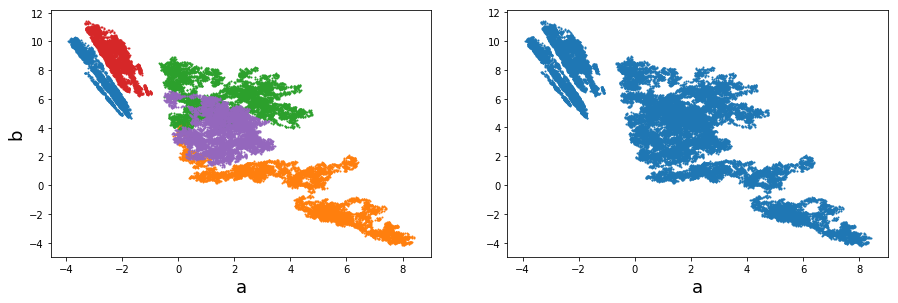

ValueError: not enough values to unpack (expected 6, got 5)

In [68]:
data = [x,y,y_err]
sigma = 0.05
a_ini = np.array([-2.0,0.0,-0.5,-1,0.5])
b_ini = np.array([5.0,4.4,6.1,6.5,5.4])
f_ini = np.array([0.1,0.04,0.1,0.5,0.01])
flags = 100
a,b,f, a_T,b_T,f_T= metrop(a_ini,b_ini,f_ini,data,sigma,flags)